# Определение стоимости автомобилей

***Описание проекта:*** 
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

***Цель исследования:***
Нужно построить модель для определения стоимости автомобилей с пробегом для привлечения новых клиентов. 

***Описание данных:***

Данные находятся в файле /datasets/autos.csv.

В них представлены следующие признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак: Price — цена (евро)**


***Основные шаги исследования***
1. Загрузить данные.

2. Изучить данные.

3. Подготовить выборки для обучения моделей.

4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг.

5. Проанализировать время обучения, время предсказания и качество моделей.

6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

***Примечания:***
- для оценки качества моделей применять метрику RMSE;
- значение метрики RMSE должно быть меньше 2500;
- самостоятельно освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга;
- время выполнения ячейки кода Jupyter Notebook можно получить специальной командой, найти её;
- модель градиентного бустинга может долго обучаться, поэтому изменить у неё только два-три параметра;
- если перестанет работать Jupyter Notebook, удалить лишние переменные оператором del.

## Подготовка данных

Сначала установим необходимые библиотеки:

In [1]:
!pip install -U -q scikit-learn

Далее импортируем библиотеки, необходимые для работы:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

Считываем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм autos. Путь к файлу - /datasets/autos.csv:

In [3]:
autos = pd.read_csv('/datasets/autos.csv')

Проверим, что данные в таблице соответствуют описанию. Выведем одну случайную строку датафрейма:

In [4]:
autos.sample(1)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
126975,2016-03-09 09:42:55,0,NaN,1995,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-09 00:00:00,0,4318,2016-03-11 13:45:55


Таким образом, представленные исходные данные соответствуют описанию.

Проведём предобработку данных.

Для начала создадим  2 функции: 
- data_main_info, которая будет выводить общую информацию о каждом датафрейме с помощью методов: info() и head();
- data_preprocessing, которая будет определять количество пропущенных значений в каждом столбце и искать явные дубликаты:

In [5]:
def data_main_info(data):
       
    print(f'Общая информация:') 
    print(data.info())
    print()
    print(f'Первые пять строк таблицы:')
    display(data.head())

In [6]:
def data_preprocessing(data):
    print(f'Количество пропущенных значений в каждом столбце:')
    print(data.isna().sum())
    print()   
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')

Рассмотрим общую информацию о датафрейме:

In [7]:
data_main_info(autos)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes:

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В выборке имеется 354369 строк и 16 столбцов, а все типы данных соответствуют содержимому.

Проверим данные на наличие пропусков и дубликатов:

In [8]:
data_preprocessing(autos)

Количество пропущенных значений в каждом столбце:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество явных дубликатов: 4


В 5 столбцах из 16 присутствуют пропущенные значения. 

Удалим неинформативные признаки, которые не влияют на рыночную стоимость автомобиля:
- DataCrawled - дата скачивания анкеты из базы;
- RegistrationMonth - месяц регистрации автомобиля;
- DataCreated - дата создания анкеты;
- NumberOfPictures - количество фотографий автомобиля;
- PostalCode - почтовый индекс владельца анкеты (пользователя);
- LastSeen - дата последней активности пользователя.

При этом посмотрим, в каком промежутке были созданы анкеты, чтобы понимать, где верхняя граница года регистрации автомобиля.

In [9]:
autos['DateCreated'].sort_values()

61207     2014-03-10 00:00:00
4001      2015-03-20 00:00:00
342275    2015-06-18 00:00:00
86601     2015-08-07 00:00:00
175103    2015-08-10 00:00:00
                 ...         
134418    2016-04-07 00:00:00
176987    2016-04-07 00:00:00
206303    2016-04-07 00:00:00
309336    2016-04-07 00:00:00
305430    2016-04-07 00:00:00
Name: DateCreated, Length: 354369, dtype: object

In [10]:
autos = autos.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated','NumberOfPictures', 'PostalCode', 'LastSeen'])

Теперь приведём названия оставшихся столбцов в соответствие правилам синтаксиса:

In [11]:
autos = autos.rename(columns={'Price':'price',
                              'VehicleType':'vehicle_type',
                              'RegistrationYear':'registration_year',
                              'Gearbox':'gearbox',
                              'Power':'power',
                              'Model':'model',
                              'Kilometer':'kilometer',
                              'FuelType':'fuel_type',
                              'Brand':'brand',
                              'Repaired':'repaired'})

autos.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Поскольку корректно заполнить пропуски в столбцах навтоматическим способом (с помощью SimpleImputer) не представляется возможным, т.к. каждый автомобиль имеет уникальные характеристики, заполним пропущенные значения константой 'no_value':

In [12]:
autos = autos.fillna('unknown')

In [13]:
# Также заменим нули, если они там имеются, в количественных входных признаках 'registration_year' и 'power' с помощью пайплайна с SimpleImputer:
# num_pipe = Pipeline(
#    [
#        (
#            'simpleImputer_num', 
#            SimpleImputer(missing_values=0, strategy='median')
#        )
#    ]
#)

In [14]:
#num_cols = ['registration_year', 'power']

In [15]:
# = autos[num_cols] 

#autos_num_cols = pd.DataFrame(
#num_pipe.fit_transform(autos_num_cols), 
#    columns=num_pipe.get_feature_names_out())

#autos_num_cols = autos_num_cols.set_index(autos.index)

#autos_num_cols.head()

In [16]:
#autos[num_cols] = autos_num_cols

#autos.head()

Снова вызовем функцию data_preprocessing:

In [17]:
data_preprocessing(autos)

Количество пропущенных значений в каждом столбце:
price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Количество явных дубликатов: 45040


Как можно видеть, пропущенные значения в столбцах отсутствуют.

Однако вместо 4 строк-дубликатов, теперь стало 45040. Это более 10 % от исходного объёма данных, тем не менее удалим их для корректной работы моделей машинного обучения: 

In [18]:
autos = autos.drop_duplicates()

In [19]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              309329 non-null  int64 
 1   vehicle_type       309329 non-null  object
 2   registration_year  309329 non-null  int64 
 3   gearbox            309329 non-null  object
 4   power              309329 non-null  int64 
 5   model              309329 non-null  object
 6   kilometer          309329 non-null  int64 
 7   fuel_type          309329 non-null  object
 8   brand              309329 non-null  object
 9   repaired           309329 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


В результате в данных осталось 309329 строк и 10 столбцов (9 входных признаков и 1 целевой признак).

Теперь проверим столбцы с типом данных object на наличие неявных дубликатов с помощью метода unique():

In [20]:
autos['vehicle_type'].unique()              

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [21]:
autos['gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [22]:
autos['model'].unique()

array(['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'other',
       'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo',
       'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',

В этом большом списке можно обнаружить, что есть неявные дубликаты: 'rangerover' и 'range_rover'. Удалим их:

In [23]:
autos['model'] = autos['model'].replace('rangerover', 'range_rover')

Перейдём к другим столбцам:

In [24]:
autos['fuel_type'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

И petrol, и gasoline обозначают бензин, а значит, можно заменить одно название другим:

In [25]:
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')

In [26]:
autos['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [27]:
autos['repaired'].unique()

array(['unknown', 'yes', 'no'], dtype=object)

Неявные дубликаты в столбце 'model' были удалены, в остальных столбцах неявные дубликаты отсутствуют.

*Таким образом, в результате предобработки данных:* 
- пропущенные значения были заменены на константу 'unknown';
- явные и неявные дубликаты были удалены;
- типы данных соответствуют содержимому столбцов;
- названия столбцов были приведены в соответствие правилам синтаксиса.

Проведём исследовательский анализ данных датафрейма autos.

Начнём с изучения статистики количественных признаков. Вызовем метод describe:

In [28]:
autos.describe()

,price,registration_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Видно, что во всех столбцах средние и медианные значения различаются, что говорит о несимметричном распределении данных в них, что будет проверено в дальнейшем.

Построим графики для каждого признака и подробнее изучим каждый из них.

Начнём со столбца целевого признака 'Price': построим столбчатую диаграмму и диаграмму размаха:

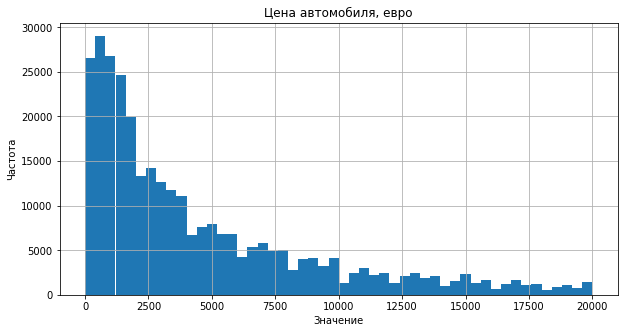

In [29]:
plt.figure(figsize=(10, 5))

autos['price'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Цена автомобиля, евро')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

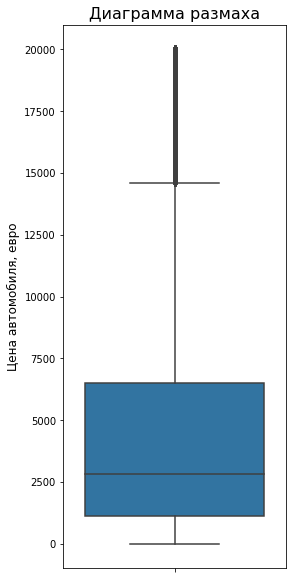

In [30]:
plt.figure(figsize=(4,10));

sns.boxplot(data=autos,y='price');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Цена автомобиля, евро", fontsize=12);

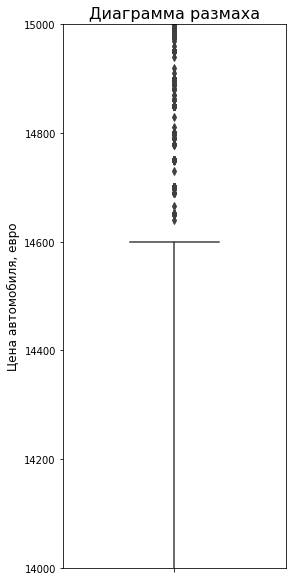

In [31]:
plt.figure(figsize=(4,10));

sns.boxplot(data=autos,y='price');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Цена автомобиля, евро", fontsize=12);
plt.ylim(14000, 15000);

In [32]:
autos.query('price > 14600')['price'].count() / len(autos) * 100

5.221624871900145

In [33]:
autos.query('price <= 100')['price'].count() / len(autos) * 100

3.9504863753479307

Как можно видеть, в столбце 'price' имеются выбросы, количество которых составляет примерно 5,2 %. Однако, поскольку это целевой признак, оставим эти данные неизменными. 

Кроме того, минимальная стоимость автомобиля в евро начинается с нуля, а поскольку значения менее, скажем, 100 евро кажутся неправдоподобными и их доля составляет всего около 4 %, удалим их:

In [34]:
autos = autos.query('price > 100')

In [35]:
autos['price'].describe()

count    297109.000000
mean       4670.933873
std        4564.857004
min         101.000000
25%        1250.000000
50%        2990.000000
75%        6750.000000
max       20000.000000
Name: price, dtype: float64

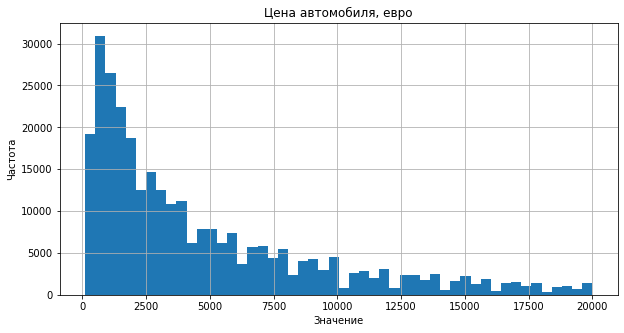

In [36]:
plt.figure(figsize=(10, 5))

autos['price'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Цена автомобиля, евро')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

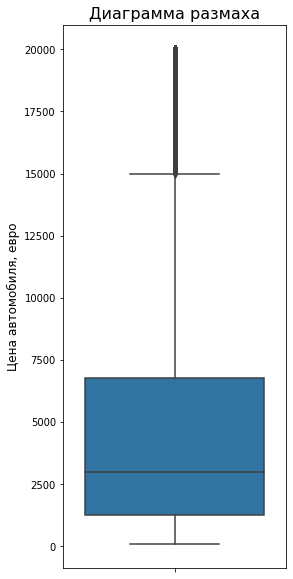

In [37]:
plt.figure(figsize=(4,10));

sns.boxplot(data=autos,y='price');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Цена автомобиля, евро", fontsize=12);

После ограничения стоимости автомобилей снизу распределение несильно изменило вид: по-прежнему виден тренд на резкое снижение количества продаваемых автомобилей по мере роста цены. А средние и медианные значения так же значительно отличаются.

Перейдём к рассмотрению данных в столбце 'registration_year':

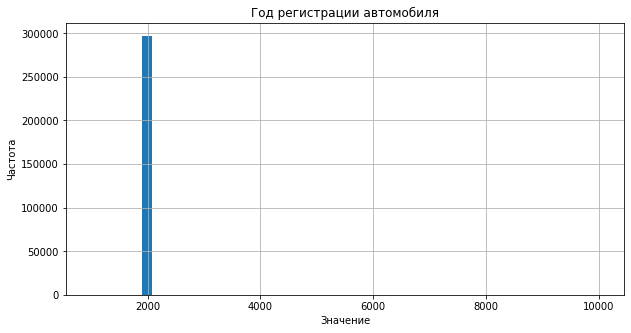

In [38]:
plt.figure(figsize=(10, 5))

autos['registration_year'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Год регистрации автомобиля')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

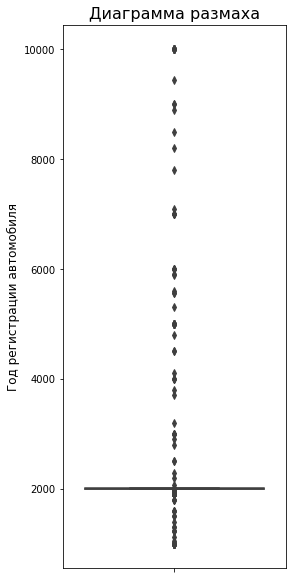

In [39]:
plt.figure(figsize=(4,10));

sns.boxplot(data=autos,y='registration_year');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Год регистрации автомобиля", fontsize=12);

В данных имеется большое количество выбросов. Поскольку первый автомобиль появился в 1886 году, а наиболее актуальные анкеты относятся к 2016 году, посмотрим, какая доля автомобилей выпадает из данного временного промежутка:

In [40]:
autos.query('registration_year < 1886 | registration_year > 2016')['registration_year'].count()\
/ len(autos) * 100

4.327031493492287

Всего около 4,3 % автомобилей не соответствуют заданному временному промежутку, удалим их из дальнейшего рассмотрения:

In [41]:
autos = autos.query('1886 <= registration_year <= 2016')

Снова исследуем столбец 'registration_year':

In [42]:
autos['registration_year'].describe()

count    284253.000000
mean       2002.656151
std           7.038365
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

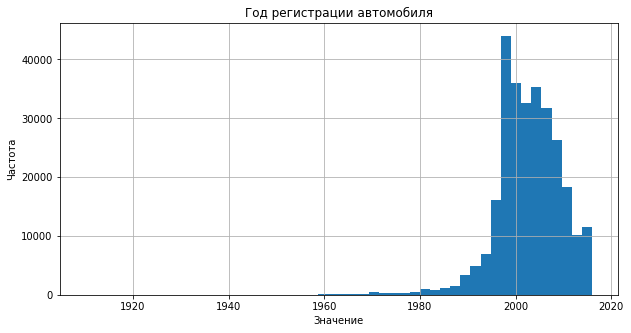

In [43]:
plt.figure(figsize=(10, 5))

autos['registration_year'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Год регистрации автомобиля')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

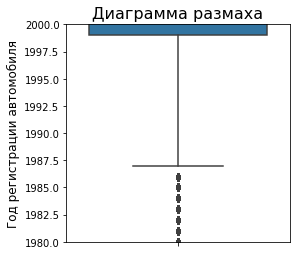

In [44]:
plt.figure(figsize=(4,4));

sns.boxplot(data=autos,y='registration_year');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Год регистрации автомобиля", fontsize=12);
plt.ylim(1980, 2000);

In [45]:
autos.query('registration_year < 1987')['registration_year'].count() / len(autos) * 100

1.9996270927659516

В среднем автомобили, предлагаемые к продаже, были зарегистрированы в 2002-2003 годах, причём автомобили до 1987 года считаются выбросами, однако их количество составляет всего около 2 %.

Далее рассмотрим данные о мощности автомобилей:

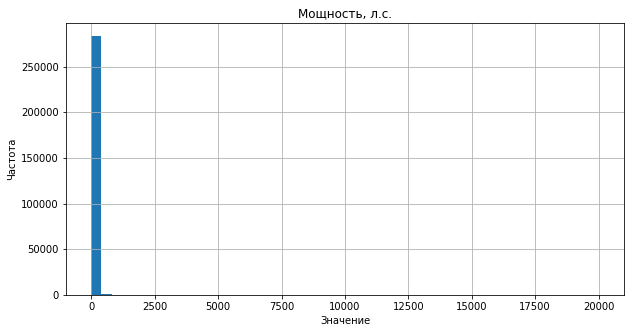

In [46]:
plt.figure(figsize=(10, 5))

autos['power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Мощность, л.с.')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

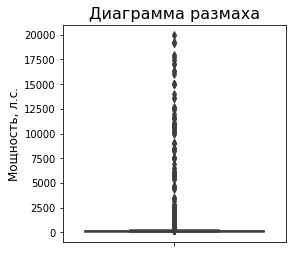

In [47]:
plt.figure(figsize=(4,4));

sns.boxplot(data=autos,y='power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Мощность, л.с.", fontsize=12);

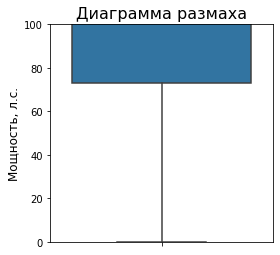

In [48]:
plt.figure(figsize=(4,4));

sns.boxplot(data=autos,y='power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Мощность, л.с.", fontsize=12);
plt.ylim(0, 100);

In [49]:
autos.query('power == 0')['power'].count() / len(autos) * 100

9.897520870492132

Мощность представленных автомобилей варьируется от 0 до 20000 л.с., причём минимальное значение возможно, если предположить что на каждом десятом продаваемом автомобиле отсутствует двигатель, а вот максимальное не отражает действительности. Так, в 2016 году, до которого мы рассматриваем автомобили, самым мощный автомобиль имел мощность 1500 л.с. Посмотрим, какая доля автомобилей выходит за данный предел мощности: 

In [50]:
autos.query('power > 1500')['power'].count() / len(autos) * 100

0.05910227860391975

Всего у около 0,06 % автомобилей указана нереалистичная мощность, удалим их из рассмотрения:

In [51]:
autos = autos.query('power <= 1500')

Посмотрим теперь, какая доля автомобилей имеет ненулевую, но очень низкую мощность, например, менее 50 л.с.:

In [52]:
autos.query('power > 0 & power < 50')['power'].count() / len(autos) * 100

1.645282221870215

У около 1,65 % автомобилей указана мощность двигателя больше 0 и меньше 50 л.с., удалим их из рассмотрения 

In [53]:
autos = autos.query('power == 0 | power >= 50')

Изучим обновлённые данные по мощности:

In [54]:
autos['power'].describe()

count    279411.000000
mean        111.260999
std          66.553221
min           0.000000
25%          75.000000
50%         106.000000
75%         143.000000
max        1500.000000
Name: power, dtype: float64

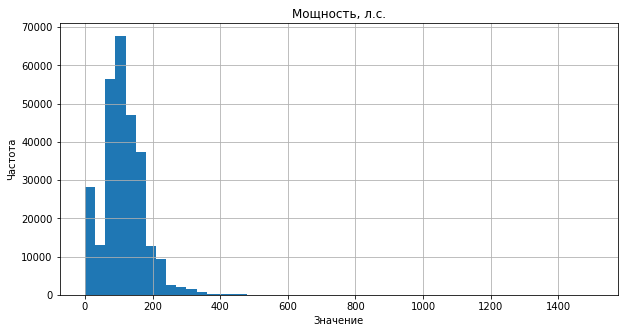

In [55]:
plt.figure(figsize=(10, 5))

autos['power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Мощность, л.с.')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

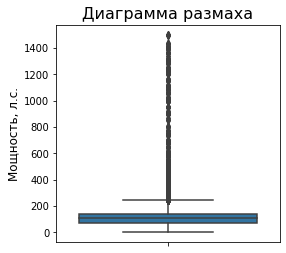

In [56]:
plt.figure(figsize=(4,4));

sns.boxplot(data=autos,y='power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Мощность, л.с.", fontsize=12);

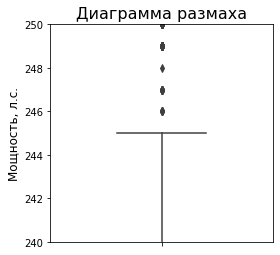

In [57]:
plt.figure(figsize=(4,4));

sns.boxplot(data=autos,y='power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Мощность, л.с.", fontsize=12);
plt.ylim(240, 250);

Основная доля автомобилей имеет мощность до 245 л.с., посмотрим, сколько % превышает это значение:

In [58]:
autos.query('power > 245')['power'].count() / len(autos) * 100

2.483796271442427

Не более 2,5 % автомобилей относятся к выбросам по значениям мощности.

Перейдём к рассмотрению пробега автомобилей:

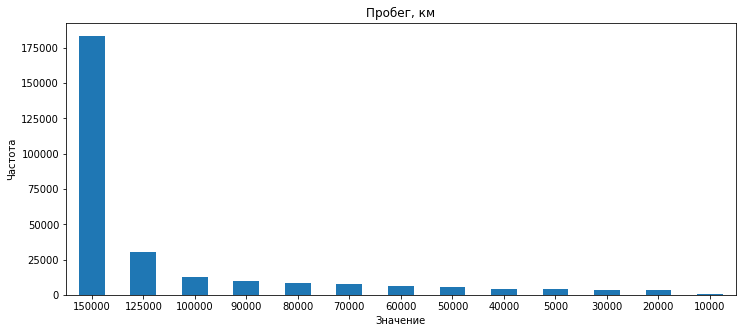

In [59]:
plt.figure(figsize=(12, 5))

autos['kilometer'].value_counts().plot(
    kind='bar',
    rot=0
);
plt.title('Пробег, км')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

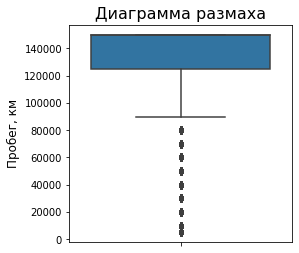

In [60]:
plt.figure(figsize=(4,4));

sns.boxplot(data=autos,y='kilometer');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Пробег, км", fontsize=12);

In [61]:
autos.query('kilometer < 90000')['kilometer'].count() / len(autos) * 100

15.607116398423827

Около 200000 автомобилей, т.е. более 50 %, имеют пробег 150000 км, причём пробег менее 90000 км считается выбросом у около 15,5 % автомобилей.

Изучим тип автомобильного кузова:

In [62]:
autos['vehicle_type'].describe()

count     279411
unique         9
top        sedan
freq       75653
Name: vehicle_type, dtype: object

In [63]:
autos['vehicle_type'].value_counts()

sedan          75653
small          61888
wagon          54628
bus            25303
convertible    17563
unknown        17112
coupe          13955
suv            10512
other           2797
Name: vehicle_type, dtype: int64

In [64]:
vehicle_type = [
    'sedan',
    'small',
    'wagon',
    'bus',
    'unknown',
    'convertible',
    'coupe',
    'suv',
    'other'
]

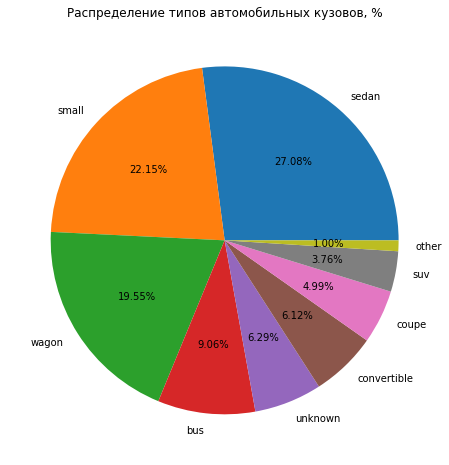

In [65]:
plt.figure(figsize=(12, 8))

plt.pie(
    x=autos['vehicle_type'].value_counts(),
    labels=vehicle_type,
    autopct='%1.2f%%',
);

plt.title('Распределение типов автомобильных кузовов, %')
plt.show();

Как можно видеть, более 1/4 всех автомобилей относятся к классу "седан", далее идут "небольшие" автомобили, а на третьем месте - "фургоны".

Теперь рассмотрим тип коробки передач:

In [66]:
autos['gearbox'].describe()

count     279411
unique         3
top       manual
freq      211838
Name: gearbox, dtype: object

In [67]:
autos['gearbox'].value_counts()

manual     211838
auto        55306
unknown     12267
Name: gearbox, dtype: int64

In [68]:
gearbox = ['manual', 'auto', 'unknown']

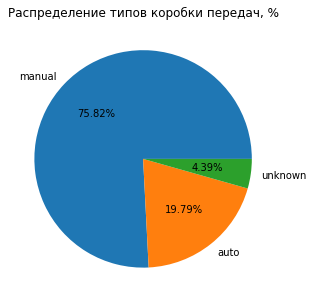

In [69]:
plt.figure(figsize=(10, 5))

plt.pie(
    x=autos['gearbox'].value_counts(),
    labels=gearbox,
    autopct='%1.2f%%',
);

plt.title('Распределение типов коробки передач, %')
plt.show();

Более 3/4 автомобилей имеют механическую коробку передач и лишь около 20 % - автоматическую коробку передач.

Теперь посмотрим, основную информацию о моделях автомобилей:

In [70]:
autos['model'].describe()

count     279411
unique       250
top         golf
freq       21332
Name: model, dtype: object

Итак, в данных имеется 250 уникальных наименований моделей автомобилей, причём наиболее популярна модель 'other', т.е. неуточнённая модель, которая имеется у 21332 автомобилей.

Далее изучим тип топлива:

In [71]:
autos['fuel_type'].describe()

count     279411
unique         7
top       petrol
freq      252770
Name: fuel_type, dtype: object

In [72]:
autos['fuel_type'].value_counts()

petrol      252770
unknown      21203
lpg           4596
cng            484
hybrid         207
other          108
electric        43
Name: fuel_type, dtype: int64

In [73]:
fuel_type = [
    'petrol',
    'unknown',
    'lpg',
    'cng',
    'hybrid',
    'other',
    'electric'
]

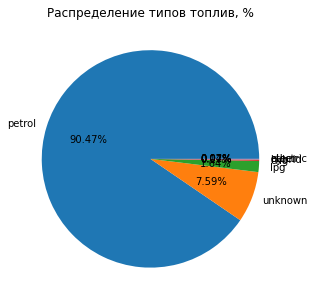

In [74]:
plt.figure(figsize=(10, 5))

plt.pie(
    x=autos['fuel_type'].value_counts(),
    labels=fuel_type,
    autopct='%1.2f%%',
);

plt.title('Распределение типов топлив, %')
plt.show();

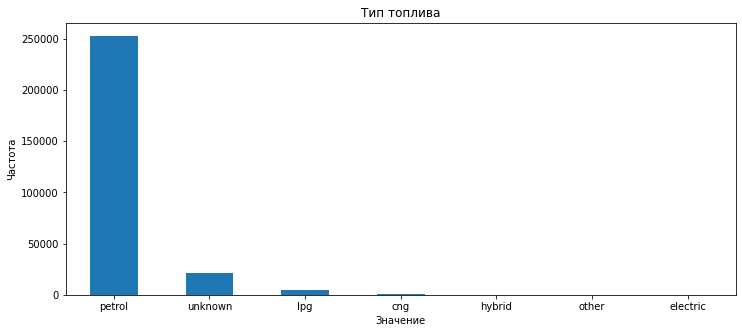

In [75]:
plt.figure(figsize=(12, 5))

autos['fuel_type'].value_counts().plot(
    kind='bar',
    rot=0
);
plt.title('Тип топлива')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();


Более 250000 (более 90%) автомобилей являются бензиновыми, а у около 7,6 % - не указан тип топлива, остальные типы топлив распределены между оставшимися 2 % автомобилей.

Теперь рассмотрим автомобильные брэнды:

In [76]:
autos['brand'].describe()

count         279411
unique            40
top       volkswagen
freq           56823
Name: brand, dtype: object

В данных имеется 40 уникальных наименований брэндов, наиболее популярен среди которых VolksWagen - более 55000 автомобилей относятся к этому автопроизводителю.

Наконец, изучим, какая доля автомобилей находилась в ремонте:

In [77]:
autos['repaired'].describe()

count     279411
unique         3
top           no
freq      198726
Name: repaired, dtype: object

In [78]:
autos['repaired'].value_counts()

no         198726
unknown     51655
yes         29030
Name: repaired, dtype: int64

In [79]:
repaired = ['no', 'unknown', 'yes']

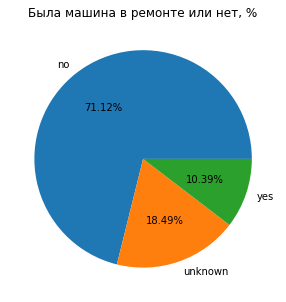

In [80]:
plt.figure(figsize=(5, 5))

plt.pie(
    x=autos['repaired'].value_counts(),
    labels=repaired,
    autopct='%1.2f%%'
);

plt.title('Была машина в ремонте или нет, %')
plt.show();

Более 70 % автомобилей не ремонтировались, около 10,5 % - проходили процедуру ремонта, а вот у почти 18,5 % нет никакой информации на этот счёт.

*Таким образом, был проведён исследовательский анализ данных, в результате которого было определено, что типичный автомобиль имеет следующие характеристики:*
- зарегистрирован в 2002-2003 гг.;
- имеет мощность двигателя в среднем 120 л.с.
- имеет пробег в среднем 150000 км;
- относится к типу седан, небольшой автомобиль или фургон;
- имеет механическую коробку передач;
- работает на бензиновом топливе;
- с вероятностью примерно 20 % относится к марке VolksWagen;
- не был в ремонте.

При этом целевой признак, т.е. стоимость автомобилей в евро, варьируется в больших пределах: от 0 до 20000.

## Обучение моделей

Перейдём к обучению моделей машинного обучения. Будем вычислять время обучения моделей на тренировочных данных и время предсказания на тестовых данных. Качество моделей будем определять метрикой RMSE (root mean squared error): её значение должно быть менее 2500.

Сначала зададим значение RANDOM_STATE:

In [81]:
# создадим константу RANDOM_STATE
RANDOM_STATE = 42

Вызовем названия столбцов датафрейма autos:

In [82]:
autos.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Далее выполним следующие действия:
- разобьём данные на тренировочную, валидационную и тестовую выборки;
- кодируем категориальные признаки с помощью OneHotEncoder и OrdinalEncoder;
- масштабируем количественные признаки с помощью StandardScaler:

In [83]:
# сохраним входные и целевые признаки
X = autos.drop(['price'], axis=1)
y = autos['price']

# сформируем тренировочную и тестовую выборки
# зафиксируем random_state
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    random_state=RANDOM_STATE,
    test_size=0.25
)

# создадим список всех категориальных признаков
cat_cols = ['vehicle_type',
            'gearbox',
            'model',
            'kilometer',
            'fuel_type',
            'brand',
            'repaired'
           ]
# создадим список всех количественных признаков
num_cols = ['registration_year',
            'power'
           ]

In [84]:
#выведем размер полученных выборок:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(209558, 9)
(209558,)

(69853, 9)
(69853,)


In [85]:
# подготовим признаки (масштабирование и кодирование) для линейных моделей:

oh_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = oh_encoder.fit_transform(X_train[cat_cols])
X_test_ohe = oh_encoder.transform(X_test[cat_cols])

oh_encoder_cols = oh_encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=oh_encoder_cols)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=oh_encoder_cols)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols)

X_train_OHE = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_OHE = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [86]:
# закодируем признаки  для остальных моделей (отмасштабированные признаки возьмём из предыдущей ячейки):

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train_oe = ord_encoder.fit_transform(X_train[cat_cols])
X_test_oe = ord_encoder.transform(X_test[cat_cols])

ord_encoder_cols = ord_encoder.get_feature_names_out()

X_train_oe = pd.DataFrame(X_train_oe, columns=ord_encoder_cols)
X_test_oe = pd.DataFrame(X_test_oe, columns=ord_encoder_cols)

X_train_OE = pd.concat([X_train_oe, X_train_scaled], axis=1)
X_test_OE = pd.concat([X_test_oe, X_test_scaled], axis=1)

Будем использовать следующие модели:
- LinearRegression без варьирования параметров;
- DecisionTreeRegressor с варьированием параметров;
- CatBoostRegressor (с градиентным бустингом) с варьированием параметров;
- LightGBMRegressor (с градиентным бустингом) с варьированием параметров.

Начнём с модели линейной регрессии. Сначала вызовем её:

In [87]:
model_lr = LinearRegression(n_jobs=-1)

Вычислим время обучения модели линейной регрессии на тренировочных данных с помощью %%timeit -n1 -r1 -o:

In [88]:
%%timeit -n1 -r1 -o
model_lr.fit(X_train_OHE, y_train)

21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

Добавим значение времени обучения линейной модели в переменную:

In [89]:
model_lr_fit_time = _

Сделаем предсказание на тренировочной выборке с помощью кросс-валидации и посчитаем метрику RMSE:

In [90]:
rmse_lr = cross_val_score(
    model_lr,
    X_train_OHE,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
).mean()

print('RMSE_linear_regression:', round(-1 * rmse_lr, 2))

RMSE_linear_regression: 2754.73


Сделаем расчёт времени предсказания, используя тренировочную выборку, и сохраним это время в переменную:

In [91]:
%%timeit -n1 -r1 -o
y_pred_lr = model_lr.predict(X_train_OHE)

193 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 193 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [92]:
model_lr_predict_time = _

Проведём моделирование с помощью следующей модели - DecisionTreeRegressor. Варьирование параметров будем осуществлять с помощью GridSearchCV:

In [93]:
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters_dtr = {
    'min_samples_split': range(2, 6),
    'min_samples_leaf': range(1, 3),
    'max_depth': range(2, 4)
}

# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 5, метрика RMSE и n_jobs=-1.
gs_dtr = GridSearchCV(
    model_dtr,
    parameters_dtr,
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

gs_dtr.fit(X_train_OE, y_train)

print('Лучшая модель и её параметры:\n\n', gs_dtr.best_params_)

Лучшая модель и её параметры:

 {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [94]:
model_dtr_best = DecisionTreeRegressor(
    random_state=RANDOM_STATE,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=3)

In [95]:
%%timeit -n1 -r1 -o
model_dtr_best.fit(X_train_OE, y_train)

131 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 131 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [96]:
model_dtr_fit_time = _

Учтём, что при использовании GridSearchCV в качестве метрики использовалась 'neg_root_mean_squared_error', поэтому результат нужно умножить на -1.

In [97]:
rmse_dtr = cross_val_score(
    model_dtr_best,
    X_train_OE,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
).mean()

print('RMSE_decision_tree_regressor:', round(-1 * rmse_dtr, 2))

RMSE_decision_tree_regressor: 2996.25


In [98]:
%%timeit -n1 -r1 -o
y_pred_dtr = model_dtr_best.predict(X_train_OE)

8.51 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 8.51 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [99]:
model_dtr_predict_time = _

Далее рассмотрим модели градиентного бустинга. Начнём с CatBoostRegressor:

In [100]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False) 

parameters_cbr = {
    'learning_rate': [.1, .5],
    'depth': range(1, 3)
}


gs_cbr = GridSearchCV(
    model_cbr,
    parameters_cbr,
    scoring='neg_root_mean_squared_error'
)

gs_cbr.fit(X_train_OE, y_train)

print('Лучшая модель и её параметры:\n\n', gs_cbr.best_params_)

Лучшая модель и её параметры:

 {'depth': 2, 'learning_rate': 0.5}


In [101]:
model_cbr_best = CatBoostRegressor(
    random_state=RANDOM_STATE,
    verbose=False,
    learning_rate=0.5,
    depth=2) 

In [102]:
%%timeit -n1 -r1 -o
model_cbr_best.fit(X_train_OE, y_train)

17.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 17.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [103]:
model_cbr_fit_time = _

In [104]:
rmse_cbr = cross_val_score(
    model_cbr_best,
    X_train_OE,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
).mean()

print('RMSE_cat_boost_regressor:', round(-1 * rmse_cbr, 2))

RMSE_cat_boost_regressor: 1763.65


In [105]:
%%timeit -n1 -r1 -o
y_pred_cbr = model_cbr_best.predict(X_train_OE)

146 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 146 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [106]:
model_cbr_predict_time = _

Вторая модель градиентного бустинга - LightGBMRegressor:

In [107]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE) 

parameters_lgbm = {
    'learning_rate': [.1, .5],
    'num_leaves': [25, 50]
}

gs_lgbm = GridSearchCV(
    model_lgbm,
    parameters_lgbm,
    scoring='neg_root_mean_squared_error'
)

gs_lgbm.fit(X_train_OE, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lgbm.best_params_)

Лучшая модель и её параметры:

 {'learning_rate': 0.5, 'num_leaves': 50}


In [108]:
model_lgbm_best = LGBMRegressor(
    random_state=RANDOM_STATE,
    learning_rate=0.5,
    num_leaves=50) 

In [109]:
%%timeit -n1 -r1 -o
model_lgbm_best.fit(X_train_OE, y_train)

8.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 8.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [110]:
model_lgbm_fit_time = _

In [111]:
rmse_lgbm = cross_val_score(
    model_lgbm_best,
    X_train_OE,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
).mean()

print('RMSE_light_gbm_regressor:', round(-1 * rmse_lgbm, 2))

RMSE_light_gbm_regressor: 1696.17


In [112]:
%%timeit -n1 -r1 -o
y_pred_lgbm = model_lgbm_best.predict(X_train_OE)

1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [113]:
model_lgbm_predict_time = _

*Таким образом, было обучено 4 модели машинного обучения для предсказания стоимости автомобилей.*

## Анализ моделей

Построим итоговую таблицу с временем обучения, временем предсказания и качеством предсказания метрикой RMSE:

In [114]:
# объединяем результаты в одну таблицу
result = pd.DataFrame([
    [model_lr_fit_time, model_lr_predict_time, round(-1 * rmse_lr, 2)],
    [model_dtr_fit_time, model_dtr_predict_time, round(-1 * rmse_dtr, 2)],
    [model_cbr_fit_time, model_cbr_predict_time, round(-1 * rmse_cbr, 2)],
    [model_lgbm_fit_time, model_lgbm_predict_time, round(-1 * rmse_lgbm, 2)]
])

result.index = [
    'LinearRegresson',
    'DecisionTreeRegressor',
    'CatBoostRegressor',
    'LightGBMRegressor'
]

result.columns = ['fit_time', 'predict_time', 'RMSE_score']

display(result)

,fit_time,predict_time,RMSE_score
LinearRegresson,21 s ± 0 ns per loop (mean ± std. dev. of 1 ru...,193 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,2754.73
DecisionTreeRegressor,131 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,8.51 ms ± 0 ns per loop (mean ± std. dev. of 1...,2996.25
CatBoostRegressor,17.9 s ± 0 ns per loop (mean ± std. dev. of 1 ...,146 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,1763.65
LightGBMRegressor,8.67 s ± 0 ns per loop (mean ± std. dev. of 1 ...,1.1 s ± 0 ns per loop (mean ± std. dev. of 1 r...,1696.17


Самой быстрой по обучению и предсказанию оказалась модель DecisionTreeRegressor. Однако метрика RMSE для этой модели равна почти 3000, что значительно выше 2500.



Модели градиентного бустинга оказались значительно медленнее, на одном уровне с моделью линейной регрессии: их время обучения составляет от 9 до 18 секунд, а время предсказания - от 150 мс до 1 с, однако наименьшая метрика RMSE зафиксирована у LightGBMRegressor. 

В целом, для модели LightGBMRegressor показатели лучше, чем у CatBoostRegressor, хотя и время предсказания значительно выше: 1 с против 150 мс, поэтому будем считать первую лучшей моделью. 

Наконец, на примере наилучшей модели посмотрим, какие входные признаки сильнее всего влияют на стоимость автомобилей, вызвав атрибут feature_importances_:

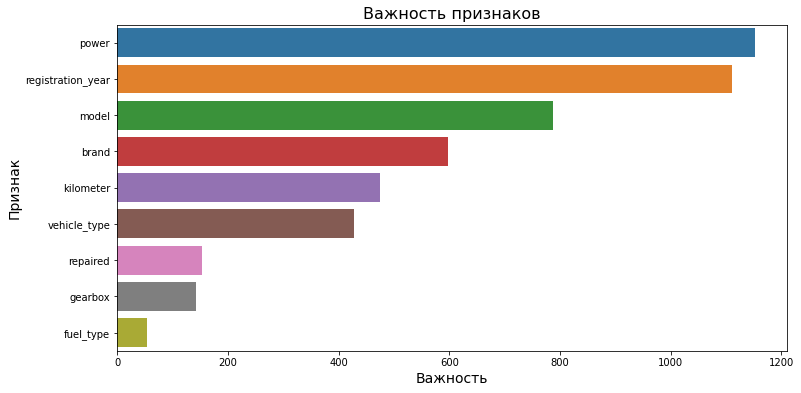

In [115]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_OE.columns,
        'Importance': model_lgbm_best.feature_importances_
    }
).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))

ax=sns.barplot(x='Importance', y='Feature', data=feature_importances)

ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

Как можно видеть, сильнее всего определяют стоимость автомобиля такие факторы, как: мощность, год регистрации и модель. А вот наименьшее влияние на стоимость оказывают тип топлива, тип коробки передач и наличие ремонта.

Рассчитаем метрику RMSE на тестовой выборке, используя модель LightGBMRegressor:

In [116]:
y_pred_best = model_lgbm_best.predict(X_test_OE)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
print('RMSE на тестовой выборке:', round(rmse_best, 2))

RMSE на тестовой выборке: 1670.01


Метрика RMSE на тестовой выборке составила 1670, что является достаточно хорошим показателем, удовлетворяющим условию в 2500.

***Выводы:***

1. Подготовка данных:

В этой задаче было представлена таблица с данными об автомобилях, где целевым признаком являлась стоимость ('price).

Изначальная таблица содержала 354369 строк и 16 столбцов.

В результате предобработки данных:
- пропущенные значения в категориальных признаках были заменены на константу 'no_value';
- нули в количественных признаках (кроме целевого) заменялись на медиану с помощью пайплайна с SimpleImputer;
- явные и неявные дубликаты были удалены, причём явных дубликатов было более 45000;
- типы данных соответствуют содержимому столбцов;
- названия столбцов были приведены в соответствие правилам синтаксиса.

На основании исследовательского анализа тренировочной выборки можно сказать, что среднестатистический автомобиль:
- зарегистрирован в 2002-2003 гг.;
- имеет мощность двигателя в среднем 120 л.с.
- имеет пробег в среднем 150000 км;
- относится к типу седан, небольшой автомобиль или фургон;
- имеет механическую коробку передач;
- работает на бензиновом топливе;
- с вероятностью примерно 20 % относится к марке VolksWagen;
- не был в ремонте.

2. Обучение моделей:

Поскольку предсказание стоимости автомобилей представляет собой задачу регресии, применялись четыре модели: линейная (LinearRegression), дерево решений (DecisionTreeRegressor) и 2 модели градиентного бустинга (CatBoostRegressor и LightGBMRegressor).

Для всех моделей, кроме линейной, гиперпараметры подбирались с помощью GridSearchCV. Категориальные признаки кодировались с помощью OneHotEncoder в случае линейной регрессии и с помощью OrdinalEncoder в остальных случаях, а количественные признаки масштабировались методом StandardScaler().

Обучение и предсказание осуществлялось с помощью тренировочной выборки.

3. Анализ моделей:

Здесь выбор и проверка качества лучшей модели основывался на трёх показателях: время обучения модели, время предсказания модели и значение метрики RMSE, которая должна была принимать значения менее 2500 для тестовой выборки, чтобы модель можно было считать качественной.
Метрика рассчитывалась с помощью кросс-валидации.

Таким образом, наилучшей моделью с учётом трёх требуемых показателей является модель LightGBMRegressor:
- время обучения: 8,67 с;
- время предсказания: 1,1 с;
- метрика RMSE: 1670,01 на тестовой выборке.